# Explore syntax parsing for detection of opinion targets and sentiments
- select candidate opinion targets
- find meaningful opinion triggers associated with targets (e.g., ADJ)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
import json

In [4]:
review_data_file = '../lexicon/data/yelp_sample.json'
with open(review_data_file, 'r') as infile:
    R = json.load(infile)

In [5]:
def spacy_sentences(nlp, text):
    sentences = []
    for sent in nlp(text).sents:
        sentences.append(sent)
    return sentences

In [6]:
R[0]

{'content': "Red, white and bleu salad was super yum and a great addition to the menu! This location was clean with great service and food served at just the right temps! Kids pizza is always a hit too with lots of great side dish options for the kiddos! When I'm on this side of town, this will definitely be a spot I'll hit up again!",
 'date': '2014-02-17',
 'stars': 4,
 'useful': 1,
 'funny': 0,
 'cool': 0,
 'business': 'Ue6-WhXvI-_1xUIuapl0zQ',
 'id': '----X0BIDP9tA49U3RvdSQ',
 'categories': ['American (Traditional)', 'Burgers', 'Restaurants']}

In [7]:
sample = spacy_sentences(nlp, R[0]['content'])

In [8]:
sample

[Red, white and bleu salad was super yum and a great addition to the menu!,
 This location was clean with great service and food served at just the right temps!,
 Kids pizza is always a hit too with lots of great side dish options for the kiddos!,
 When I'm on this side of town, this will definitely be a spot I'll hit up again!]

In [9]:
type(sample[0])

spacy.tokens.span.Span

## Overview of spaCy syntax parsing

In [10]:
import networkx as nx
from spacy.displacy import render

In [11]:
test = sample[1]

In [12]:
render(test)

In [13]:
data = pd.DataFrame([{
    'token_id': i, 'token': x.idx, 'text': x.text, 'pos': x.pos_, 'lemma': x.lemma_,
    'dep': x.dep_, 'head': x.head.idx
} for i, x in enumerate(test)])

In [14]:
data

,token_id,token,text,pos,lemma,dep,head
0,0,74,This,DET,this,det,79
1,1,79,location,NOUN,location,nsubj,88
2,2,88,was,AUX,be,ROOT,88
3,3,92,clean,ADJ,clean,acomp,88
4,4,98,with,ADP,with,prep,92
5,5,103,great,ADJ,great,amod,109
6,6,109,service,NOUN,service,pobj,98
7,7,117,and,CCONJ,and,cc,109
8,8,121,food,NOUN,food,conj,109
9,9,126,served,VERB,serve,advcl,88


## Explore the graph for detecting the target of adjectives and verbs
- hints: create a statistics of the adjectives and verbs most common dependencies

In [15]:
token_map = lambda span: dict([(x.idx, x) for x in span])

In [16]:
def explore(token, children=None, level=0, order=None):
    if children is None:
        children = []
    if order is None:
        order = token.idx
    for child in token.children:
        children.append((child, level, child.idx < order))
        explore(child, children=children, level=level+1, order=order)
    return children

In [17]:
token = list(test)[6]
print(token)
print(explore(token), '\n')
print(test)

service
[(great, 0, True), (and, 0, False), (food, 0, False)] 

This location was clean with great service and food served at just the right temps!


### Left side adjectives
Search for adjectives on the left side of the dependency tree but exclude adjectives found after another noun in the tree

In [18]:
def search_adjectives(nlp_text, nouns=None):
    nouns_map = dict([(x, []) for x in nlp_text if x.pos_ in ['NOUN', 'PROPN']])
    if nouns is None:
        nouns = nouns_map.keys()
    else:
        pass
    for noun in nouns:
        subtree = explore(noun)
        subnouns = [(x, l) for x, l, _ in subtree if x.pos_ in ['NOUN', 'PROPN']]
        for token, level, left in subtree:
            if token.pos_ == 'ADJ' and len([(n, l) for n, l in subnouns if l < level]) == 0:
                try:
                    nouns_map[noun].append(token)
                except KeyError:
                    pass
    return nouns_map

In [19]:
print(search_adjectives(test))
print(test)

{location: [], service: [great], food: [], temps: [right]}
This location was clean with great service and food served at just the right temps!


### Verb patterns
Search for the pattern
$$
NOUN \rightarrow BE\ (VERB)\ \rightarrow ADJ
$$
For the noun, we search for a subject. For the adjective:
- get only `dobj`, `attr` and `conj` **or** level 0 adjectives
- add level 0 adjectives to the adjective map for the corresponding subject noun
- for nouns, get the adjective map and add the adjectives to the subject

**Important** in this example we do not deal with negation. Address negation as an exercise.

In [20]:
def verb_adjectives(text, adjective_map, be_only=True):
    if be_only:
        verbs = [x for x in text if x.lemma_ == 'be']
    else:
        verbs = [x for x in text if x.pos_ in {'AUX', 'VERB'}]
    for verb in verbs:
        subtokens = explore(verb)
        subject = [(x) for x, level, left in subtokens if left and x.dep_ == 'nsubj']
        if len(subject) > 0:
            subj = subject[0]
            for candidate, level, left in subtokens:
                if not left:
                    if candidate.pos_ == 'ADJ' and level == 0:
                        try:
                            adjective_map[subj].append(candidate)
                        except KeyError:
                            pass
                    elif candidate.dep_ in ['dobj', 'attr', 'conj']:
                        adj = search_adjectives(text, nouns=[candidate])
                        try:
                            adjective_map[subj] += adj[candidate]
                        except KeyError:
                            pass
                    else:
                        pass

In [21]:
adj_map = search_adjectives(test)
verb_adjectives(test, adj_map)
print(adj_map)
print(test)

{location: [clean], service: [great], food: [], temps: [right]}
This location was clean with great service and food served at just the right temps!


### Example

In [22]:
test = spacy_sentences(nlp, R[0]['content'])[0]
print(test)

Red, white and bleu salad was super yum and a great addition to the menu!


In [23]:
nm = search_adjectives(test)
nm

{bleu: [], salad: [Red, white], yum: [super], addition: [great], menu: []}

In [24]:
verb_adjectives(test, adjective_map=nm)

In [25]:
nm

{bleu: [],
 salad: [Red, white, super, great],
 yum: [super],
 addition: [great],
 menu: []}

### Exercise: look at negations and find a way to address them

In [26]:
s = nlp("this salad wasn't good")
nms = search_adjectives(s)
verb_adjectives(s, adjective_map=nms)
nms
render(s)

## Find meaningful pairs ADJ-NOUN per business category
We now exploit our search functions to get stats about the adjective-noun pairs and the corresponding business categories.

In [27]:
documents, stars, categories = [], [], []
for i, review in enumerate(R[:3000]):
    documents.append(review['content'])
    stars.append(review['stars'])
    categories.append(review['categories'])

In [28]:
categories[0]

['American (Traditional)', 'Burgers', 'Restaurants']

In [29]:
stats_data = []
runs = list(enumerate(documents))
for i, doc in tqdm(runs):
    cats = categories[i]
    star = stars[i]
    sample = spacy_sentences(nlp, doc)
    for sent in sample:
        nm = search_adjectives(sent)
        verb_adjectives(sent, adjective_map=nm)
        for n, adjs in nm.items():
            for a in adjs:
                for cat in cats:
                    stats_data.append({
                        'doc': i,
                        'category': cat,
                        'adj': a.lemma_.lower(),
                        'noun': n.lemma_.lower()
                    })
S = pd.DataFrame(stats_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [30]:
S.head()

,doc,category,adj,noun
0,0,American (Traditional),red,salad
1,0,Burgers,red,salad
2,0,Restaurants,red,salad
3,0,American (Traditional),white,salad
4,0,Burgers,white,salad


### Pointwise mutual information
We can exploit PMI for two aims:

1. compute relevance of adjective-noun pairs
2. compute relevance of nouns pairs per category

(1.) is a measure of how much an adjective is related to the corresponding noun, while (2.) gives a measure of how much a noun is relevant for a category 

The general formula for PMI given two variables A and B is:
$$
PMI(A, B) = \log \frac{P(A, B)}{P(A)P(B)} = \log \left ( \frac{count(A, B)}{\sum\limits_{i=1}^{n} count((A, B)_i)}
\frac{\sum\limits_{j=1}^{a} count(A_j)\sum\limits_{z=1}^{b} count(B_j)}{count(A)count(B)} \right )
$$
**Note**: the reliability of PMI requires a minimal number of observations. For this reason, we skip pairs of values having a low frequency

#### Adjective-Noun PMI
**NOTE** for adj-noun pairs, we first get rid of categories to avoid overcounting pairs

In [31]:
Sdoc = S.groupby(['doc', 'adj', 'noun']).first().reset_index()[['doc', 'adj', 'noun']]

In [32]:
min_freq = 2
adj_noun = Sdoc.groupby(['adj', 'noun']).count()
adj_noun = adj_noun[adj_noun.doc > min_freq]
adj = Sdoc.groupby('adj').count()['doc']
adj = pd.DataFrame(adj[adj > min_freq])
noun = Sdoc.groupby('noun').count()['doc']
noun = pd.DataFrame(noun[noun > min_freq])

In [33]:
adj_noun.head()

doc
adj        noun      
-          food     3
           place    4
1st        time     5
2nd        time     4
affordable place    3

In [34]:
adj.head()

,doc
adj,
-,52
1\/2,3
1st,7
2nd,9
3d,3


In [35]:
noun.head()

,doc
noun,
%,4
-ramon,4
90,3
\/,4
access,8


##### Probabilities

In [36]:
adj_noun_sum = adj_noun.sum()['doc']
adj_noun['p'] = adj_noun.doc / adj_noun_sum
adj_sum = adj.sum()['doc']
adj['p'] = adj.doc / adj_sum
noun_sum = noun.sum()['doc']
noun['p'] = noun.doc / noun_sum

##### PMI

In [37]:
pmi = []
for (a, n), row in adj_noun.iterrows():
    pmi.append({'adj': a, 'noun': n, 'pmi': np.log(row.p / (adj.loc[a].p * noun.loc[n].p))})
pmi_an = pd.DataFrame(pmi)
pmi_an.set_index(['adj', 'noun'], inplace=True)

In [38]:
pmi_an.sort_values('pmi', ascending=False).head()

,,pmi
adj,noun,
bloody,mary,8.531200
human,being,8.466662
military,discount,8.377050
olive,oil,8.348879
balsamic,vinegar,8.328259


#### Category-noun PMI

In [39]:
Scat = S.groupby(['category', 'noun']).count().reset_index()[['category', 'noun', 'doc']]

In [40]:
cat_noun = Scat[Scat.doc > min_freq].copy()
cat_p = pd.DataFrame(cat_noun.groupby('category')['doc'].sum())
cat_p = cat_p[cat_p.doc > min_freq]
noun_p = pd.DataFrame(cat_noun.groupby('noun')['doc'].sum())
noun_p = noun_p[noun_p.doc > min_freq]

In [41]:
cat_noun_sum = cat_noun.doc.sum()
cat_noun['p'] = cat_noun.doc / cat_noun_sum
cat_p['p'] = cat_p.doc / cat_p.doc.sum()
noun_p['p'] = noun_p.doc / noun_p.doc.sum()

In [42]:
pmi = []
for i, row in cat_noun.iterrows():
    pmi.append({'category': row['category'], 
                'noun': row['noun'], 
                'pmi': np.log(
                    row.p / (cat_p.loc[row['category']].p * noun_p.loc[row['noun']].p))})
pmi_cat = pd.DataFrame(pmi)
pmi_cat.set_index(['category', 'noun'], inplace=True)

In [43]:
pmi_cat.sort_values('pmi', ascending=False).head()

,,pmi
category,noun,
Test Preparation,colleague,9.228655
Public Services & Government,ppl,8.823190
Orthopedists,surgery,8.823190
Beaches,beach,8.823190
Sports Medicine,news,8.823190


In [44]:
pmicats = pmi_cat.reset_index()
pmicats[pmicats.category == 'Hotels & Travel'].sort_values('pmi', ascending=False).head()

,category,noun,pmi
4012,Hotels & Travel,condition,3.977255
3991,Hotels & Travel,bag,3.977255
4051,Hotels & Travel,luck,3.977255
3988,Hotels & Travel,airport,3.358215
3989,Hotels & Travel,alain,3.284107


# Use PMI data for predicting the sentiment score of each aspect
We assume that `NOUNS` represent different opinion targets in a review.

For each `NOUN` (i.e., target in our interpretation), we know:
1. the corresponding `ADJ`
2. the corresponding `CATEGORY` 
3. the expected number of `STARS` of the review as a whole.

We aim at predicting (3.) given (1.) and (2.).

In [45]:
categories, adjs, nouns = S.category.values, S.adj.values, S.noun.values
S['stars'] = [stars[x] for x in S.doc.values]
S['pmi_cat'] = [pmi_cat.loc[(categories[i], nouns[i])].pmi if (
    categories[i], nouns[i]) in pmi_cat.index else np.nan for i in range(S.shape[0])]
S['pmi_an'] = [pmi_an.loc[(adjs[i], nouns[i])].pmi if (
    adjs[i], nouns[i]) in pmi_an.index else np.nan for i in range(S.shape[0])]

In [46]:
S.sort_values('pmi_an', ascending=False).head()

,doc,category,adj,noun,stars,pmi_cat,pmi_an
14733,459,Nightlife,bloody,mary,1,NaN,8.5312
27383,830,Restaurants,bloody,mary,3,1.095948,8.5312
56578,1701,Restaurants,bloody,mary,1,1.095948,8.5312
56577,1701,Casinos,bloody,mary,1,NaN,8.5312
56576,1701,Buffets,bloody,mary,1,NaN,8.5312


In [47]:
Sn = S.dropna(inplace=False)

In [48]:
Sn.shape

(28409, 7)

## Example 1: regression
The number of stars is interpreted as a continuous scale.

In [49]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [50]:
X, y = Sn[['pmi_cat', 'pmi_an']], Sn.stars.values

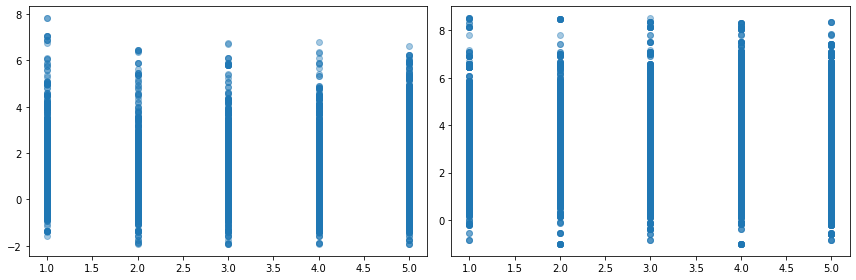

In [51]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].scatter(y, X.pmi_cat.values, alpha=.4)
ax[1].scatter(y, X.pmi_an.values, alpha=.4)
plt.tight_layout()
plt.show()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.head()

,pmi_cat,pmi_an
81087,2.698979,1.807765
10450,0.016897,1.926909
22822,-0.033994,2.851711
92176,0.186733,2.109835
3507,0.021118,0.164703


### Regression

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [55]:
scaler = MinMaxScaler()

In [56]:
Xs_train = scaler.fit_transform(np.array(X_train))
Xs_test = scaler.transform(np.array(X_test))

In [57]:
reg = LinearRegression()
reg = reg.fit(Xs_train, y_train)

In [58]:
train_prediction = reg.predict(Xs_train)
test_prediction = reg.predict(Xs_test)

In [59]:
print(mean_squared_error(y_train, train_prediction))
print(mean_squared_error(y_test, test_prediction))

1.7788131956210327
1.834939131748545


### Example

In [60]:
aspect = ('Restaurants', 'good', 'service')
vector = scaler.transform(
    np.array([[pmi_cat.loc[(aspect[0], aspect[2])].pmi, pmi_an.loc[(aspect[1], aspect[2])].pmi]]))
print(S[(S.category == aspect[0]) & (S.adj == aspect[1]) & (S.noun == aspect[2])].stars.values.mean())
print(reg.predict(vector))

3.5714285714285716
[3.79490392]


## Example 2: categorical approach
We create some pseudo features composed by pairs `(category, noun)` and `(adj, noun)` and we use pmi as scores.

In [61]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(Sn[['pmi_cat', 'pmi_an']].values)

In [62]:
features = list(pmi_an.index.values) + list(pmi_cat.index.values)

In [63]:
X = np.zeros((Sn.shape[0], len(features)))
categories, adjs, nouns = Sn.category.values, Sn.adj.values, Sn.noun.values
for i, c in enumerate(categories):
    a = adjs[i]
    n = nouns[i]
    X[i, features.index((c, n))] = scaled[i,0]
    X[i, features.index((a, n))] = scaled[i,1]

### Classifiers

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [65]:
y = Sn.stars.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

In [88]:
dc = DecisionTreeClassifier(max_leaf_nodes=3)
dc.fit(X_train, y_train)
dc_pred = dc.predict(X_test)

In [89]:
print(classification_report(y_test, dc_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.67      0.04      0.08       914
           2       0.00      0.00      0.00       786
           3       0.00      0.00      0.00      1193
           4       0.00      0.00      0.00      2311
           5       0.39      1.00      0.56      3319

    accuracy                           0.39      8523
   macro avg       0.21      0.21      0.13      8523
weighted avg       0.22      0.39      0.23      8523



### Explanation (local)

In [97]:
def local_explanation(dc, sample_id, features, verbose=False):
    n_nodes = dc.tree_.node_count
    children_left = dc.tree_.children_left
    children_right = dc.tree_.children_right
    feature = dc.tree_.feature
    threshold = dc.tree_.threshold
    node_indicator = dc.decision_path(X_test)
    leaf_id = dc.apply(X_test)
    
    relevant_features = []

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    if verbose:
        print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        
        relevant_features.append(features[feature[node_id]])

        if verbose:
            print(
                "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
                "{inequality} {threshold})".format(
                    node=node_id,
                    sample=sample_id,
                    feature=features[feature[node_id]],
                    value=X_test[sample_id, feature[node_id]],
                    inequality=threshold_sign,
                    threshold=threshold[node_id],
                )
        )
    return relevant_features

In [98]:
relevant = local_explanation(dc, sample_id=0, features=features, verbose=True)

Rules used to predict sample 0:

decision node 0 : (X_test[0, ('bad', 'service')] = 0.0) <= 0.1615559160709381)
decision node 1 : (X_test[0, ('horrible', 'service')] = 0.0) <= 0.21718505024909973)


In [99]:
print(relevant)

[('bad', 'service'), ('horrible', 'service')]


### Explanation (global)

In [102]:
from collections import defaultdict

In [107]:
global_e = defaultdict(lambda: defaultdict(lambda: 0))
run = list(range(100))
for i in tqdm(run):
    predition = dc_pred[i]
    rel = local_explanation(dc, sample_id=i, features=features, verbose=False)
    for f in rel:
        global_e[predition][f] += 1

  0%|          | 0/100 [00:00<?, ?it/s]

In [109]:
G = pd.DataFrame(global_e)
G.head()

,,5,1
bad,service,99,1.0
horrible,service,99,NaN


### Born
[https://eguidotti.github.io/bornrule/](https://eguidotti.github.io/bornrule/)

In [67]:
from bornrule import BornClassifier

In [68]:
bc = BornClassifier()
bc.fit(X_train, y_train)
bc_pred = bc.predict(X_test)

In [69]:
print(classification_report(y_test, bc_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.35      0.60      0.44       914
           2       0.26      0.46      0.33       786
           3       0.32      0.41      0.36      1193
           4       0.49      0.34      0.40      2311
           5       0.66      0.49      0.56      3319

    accuracy                           0.45      8523
   macro avg       0.42      0.46      0.42      8523
weighted avg       0.50      0.45      0.46      8523



### Explanation

In [70]:
E = pd.DataFrame(bc.explain(), index=features, columns=[str(x) for x in range(1, 6)])

In [72]:
E.sort_values('1', ascending=False).head(10)

,1,2,3,4,5
"(bad, service)",0.075266,0.045617,0.000000,0.008958,0.005224
"(poor, service)",0.067178,0.017115,0.000000,0.000000,0.000000
"(horrible, service)",0.065467,0.040893,0.016958,0.000000,0.000000
"(similar, experience)",0.059932,0.000000,0.000000,0.000000,0.000000
"(horrible, experience)",0.058187,0.020238,0.000000,0.000000,0.000000
"(awful, service)",0.056210,0.000000,0.000000,0.000000,0.000000
"(terrible, experience)",0.056077,0.000000,0.013308,0.000000,0.000000
"(terrible, service)",0.055552,0.033062,0.000000,0.011820,0.008484
"(rude, server)",0.055229,0.000000,0.000000,0.000000,0.000000
"(cold, food)",0.050539,0.018417,0.008574,0.012776,0.000000


In [82]:
E_local = pd.DataFrame(bc.explain(X[0].reshape(1, -1)), index=features, columns=[str(x) for x in range(1, 6)])

In [85]:
E_local.sort_values('5', ascending=False).head(10)

,1,2,3,4,5
"(great, salad)",0.0,0.0,0.0,0.00478,0.006155
"(Mediterranean, staff)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, salad)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, sauce)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, selection)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, service)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, space)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, spot)",0.0,0.0,0.0,0.00000,0.000000
"(-, food)",0.0,0.0,0.0,0.00000,0.000000
"(Mediterranean, rice)",0.0,0.0,0.0,0.00000,0.000000
